BSE multi-week planning
=====================

The CRC call center has about 200 agents with the following contract types:

- 50% part-time: thet work 4 hours
- 75% part-time: they work 6 hours
- full-time: they work 8 hours

A plan is made each week based on the call forecast based on the following rules

- agents work from monday to sunday
- they work on 4,6,8 hours shifts based on their contract
- they have two rest shift that must be assigned based on the following *rotation matrix*

|    | mon | tue | wed | thu | fri | sat | sun |
|----|-----|-----|-----|-----|-----|-----|-----|
|  1 | .   | .   | .   | .   | .   | R   | R   |
|  2 | .   | .   | .   | .   | R   | R   | ,   |
|  3 | .   | .   | .   | R   | R   | .   | .   |
|  4 | .   | .   | R   | R   | .   | .   | .   |
|  5 | .   | R   | R   | .   | .   | .   | .   |
|  6 | R   | R   | .   | .   | .   | .   | .   |
|  7 | .   | .   | .   | .   | .   | R   | R   |

---

- the plan must be **optimal** that is it must follow as closely as possible the target

---

In order to specify these rules we use a simple *domain specific language*:

- **shifts** are defined based on a specification line: for example

```
A1 = Shift.fromSpec("A1", "09:00-12:00")             # a 4 hour shift from 9 to 12
A2 = Shift.fromSpec("A2", "10:00-13:00")             # a 4 hour shift from 9 to 12
...
M1 = Shift.fromSpec("M1", "09:00-12:00,13:00-17:00") # a 8 hour shift from 9 to 17 with a 1 hour pause
...
R  = Shift("R")                                      # a rest shift
```

- shifts can be *combined* to form **shift rules**

```
A1 + A2      # assign either A1 or A2 on a single day

A1 * A2      # a two day assigment: assign A1 on the first day and A2 on the second

(A1+A2) * R  # a two day assignment: assign either A1 or A2 on the first day and R on the second


W = A1 + A2

X = W * W * W * W * W * R * R    # a 7 days assignment:
                                 #   assign either A1 or A2 on the first 5 days
                                 #   assign R on the weekend
```

---

To produce a plan we have to

- define the shifts and the agents and the target staffing
- based on the contract, availability, etc. we find the shifts that can be assigned to an agent
- we create a planner
- we form the shift rules and add them to the planner
- we run the planner
- we retrieve the optimized plan

In [1]:
import json
import matplotlib.pyplot as plt

from random import randint
from datetime import time
from functools import reduce
from tabulate import tabulate

from pywfplan import Shift, StaffPlanner

In [2]:
# first we import the shift specifications
# note that the pauses are specified in the shift definition

with open("shifts_bse.json") as f:
        shifts = [Shift.fromSpec(s[0], *s[1]) for s in json.load(f).items()]

In [3]:
# the rest shift

R = Shift.fromSpec("R")

In [4]:
# the the agent definitions

with open("agents_bse.json") as f:
        agents = json.load(f)

len(agents)

99

In [5]:
# random initialize agent cycle

cycle = {agent: randint(0,6) for agent in agents}

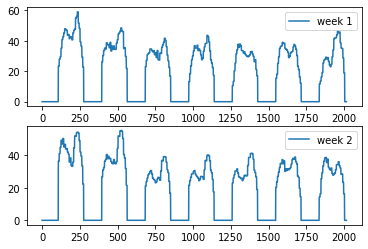

In [6]:
# the target curves from the call forecast
with open("target_bse.json") as f:
        target = json.load(f)

# rescale
N1 = 3250 / (sum(target["week1"])*5/60)
target["week1"] = [t * N1 for t in target["week1"]]

N2 = 3250 / (sum(target["week2"])*5/60)
target["week2"] = [t * N2 for t in target["week2"]]

plt.subplot(2, 1, 1)
plt.plot(target["week1"], label="week 1")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(target["week2"], label="week 2")
plt.legend()

Week 1
----------

In [7]:
# create a planner for the first week

week1Planner = StaffPlanner()

In [8]:
# configure the planner

week1Planner.setStaffingTarget(target["week1"], days=7, slot_length=5)

for code, agent in agents.items():
    
    # get work shifts for agent based on her contract
    agent_shifts = [s for s in shifts if s.is_work() and s.attrs["contract"] == agent["contract"]]
    
    W = reduce(lambda a,b: a+b, agent_shifts)
    
    # assign rest based on agent current cycle
    if cycle[code] == 0:
        rule = W * W * W * W * W * R * R
    elif cycle[code] == 1:
        rule = W * W * W * W * R * R * W
    elif cycle[code] == 2:
        rule = W * W * W * R * R * W * W
    elif cycle[code] == 3:
        rule = W * W * R * R * W * W * W
    elif cycle[code] == 4:
        rule = W * R * R * W * W * W * W
    elif cycle[code] == 5:
        rule = R * R * W * W * W * W * W
    elif cycle[code] == 6:
        rule = W * W * W * W * W * R * R
    else:
        raise Exception("invalid cycle number")
        
    # finally we add the rule to the planner
    week1Planner.addAgentRule(code, rule)

In [9]:
# at this point the planner is ready to be launched
# (it takes a few minutes)

week1Planner.run(annealing_schedule=0.9, comfort_energy_weight=0.0)

performing initial temperature calibration ...
initial temperature: 8.000000
performing final temperature calibration ...
final temperature: 0.000012
starting 127 simulated annealing steps from temperature 8.0000 (delta=0.9000) ...
  0% T=8.0000 E=36.2111 (1981 2059) ...
  1% T=7.2000 E=27.5471 (1981 2076) ...
  2% T=6.4800 E=26.7837 (1981 2093) ...
  3% T=5.8320 E=22.8077 (1981 2083) ...
  3% T=5.2488 E=22.8504 (1981 2107) ...
  4% T=4.7239 E=25.9745 (1981 2100) ...
  5% T=4.2515 E=29.6450 (1981 2123) ...
  6% T=3.8264 E=29.2644 (1981 2126) ...
  7% T=3.4437 E=19.3904 (1981 2158) ...
  7% T=3.0994 E=26.1812 (1981 2163) ...
  8% T=2.7894 E=23.7783 (1981 2186) ...
  9% T=2.5105 E=22.4186 (1981 2216) ...
 10% T=2.2594 E=21.6250 (1981 2245) ...
 11% T=2.0335 E=22.1124 (1981 2276) ...
 11% T=1.8301 E=30.8446 (1981 2298) ...
 12% T=1.6471 E=15.5175 (1981 2307) ...
 13% T=1.4824 E=19.0647 (1981 2351) ...
 14% T=1.3342 E=24.8390 (1981 2373) ...
 14% T=1.2008 E=18.7174 (1981 2395) ...
 15% T=1

In [10]:
# retrieve the optimized plan

print(tabulate([[code, cycle[code], *week1Planner.getAgentPlan(code)] for code in agents], 
      headers=["agent", "cycle", "mon", "tue", "wed", "thu", "fri", "sat", "sun"]))

agent      cycle  mon           tue           wed           thu           fri           sat           sun
-------  -------  ------------  ------------  ------------  ------------  ------------  ------------  ------------
OIA75          2  B0900         B0900         B0900         R             R             B1600         B1630
OIA95          0  C1100_240x48  C1230_52      C1430_52      C0900_44      C1000_52      R             R
OIA144         6  C0900_240x48  C1000_240x48  C1030_240x48  C1100_40      C1430_40      R             R
OIA143         1  C1200_56      C1100_40      C1000_52      C0900_240x48  R             R             C1230_56
OIA243         2  C0930_56      C1400_36      C1200_52      R             R             C1230_44      C1100_44
OIA153         1  C1430_56      C1230_40      C1000_240x48  C0930_44      R             R             C1430_40
OIA96          0  C1230_56      C1430_44      C1430_44      C1130_52      C1000_52      R             R
OIA122         3  C1030_24

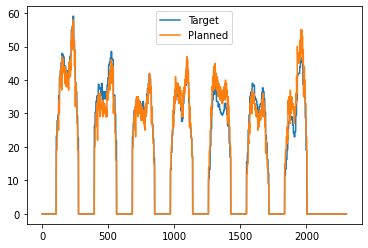

In [11]:
# and compare the planned staffing curve with the target

plt.plot(week1Planner.getTargetStaffing(), label="Target")
plt.plot(week1Planner.getPlannedStaffing(), label="Planned")
plt.legend()
plt.show()

In [12]:
# the optimization report 

print(week1Planner.getReport())


          turning length: 7
                 week n°: 0
             slot length: 5 minutes
               agents n°: 99
         target staffing: 3250.00 hrs
      simulated staffing: 3249.17 hrs

   comfort energy weight: 0.00000

         annealing steps: 127
       temperature range: 8.00000 -> 0.00001
    temperature schedule: 0.90
       optimization time: 3.0 minutes

         staffing energy: 22.16689 -> 9.25571
          comfort energy: 73707.42857 -> 107439.42857
            TOTAL ENERGY: 22.16689 -> 9.25571

     day by day staffing:
                 day   1: 550.50 hrs (target 589.81 hrs error 6.67%)
                 day   2: 456.83 hrs (target 518.17 hrs error 11.84%)
                 day   3: 424.33 hrs (target 442.87 hrs error 4.19%)
                 day   4: 460.67 hrs (target 438.53 hrs error -5.05%)
                 day   5: 474.00 hrs (target 408.06 hrs error -16.16%)
                 day   6: 382.17 hrs (target 425.94 hrs error 10.28%)
                 day   7: 500

In [13]:
# update agent cycles

for code in agents:
    cycle[code] = (cycle[code] + 1) % 7

Week 2
----------

In [14]:
# create a new planner for the second week

week2Planner = StaffPlanner()

In [15]:
# configure the planner

week2Planner.setStaffingTarget(target["week2"], days=7, slot_length=5)

for code, agent in agents.items():
    
    # get work shifts for agent based on her contract
    agent_shifts = [s for s in shifts if s.is_work() and s.attrs["contract"] == agent["contract"]]
    W = reduce(lambda a,b: a+b, agent_shifts)
    
    # assign rest based on agent current cycle
    if cycle[code] == 0:
        rule = W * W * W * W * W * R * R
    elif cycle[code] == 1:
        rule = W * W * W * W * R * R * W
    elif cycle[code] == 2:
        rule = W * W * W * R * R * W * W
    elif cycle[code] == 3:
        rule = W * W * R * R * W * W * W
    elif cycle[code] == 4:
        rule = W * R * R * W * W * W * W
    elif cycle[code] == 5:
        rule = R * R * W * W * W * W * W
    elif cycle[code] == 6:
        rule = W * W * W * W * W * R * R
    else:
        raise Exception("invalid cycle number")
    
    # finally we add the rule to the planner
    week2Planner.addAgentRule(code, rule)

In [16]:
# run planner

week2Planner.run(annealing_schedule=0.9, comfort_energy_weight=0.0)

performing initial temperature calibration ...
initial temperature: 8.000000
performing final temperature calibration ...
final temperature: 0.000040
starting 116 simulated annealing steps from temperature 8.0000 (delta=0.9000) ...
  0% T=8.0000 E=52.6608 (1981 2084) ...
  1% T=7.2000 E=52.3982 (1981 2136) ...
  2% T=6.4800 E=35.0611 (1981 2108) ...
  3% T=5.8320 E=49.4153 (1981 2121) ...
  4% T=5.2488 E=41.7687 (1981 2154) ...
  5% T=4.7239 E=39.5215 (1981 2151) ...
  6% T=4.2515 E=61.4420 (1981 2163) ...
  6% T=3.8264 E=43.8989 (1981 2200) ...
  7% T=3.4437 E=39.3580 (1981 2221) ...
  8% T=3.0994 E=41.6530 (1981 2213) ...
  9% T=2.7894 E=38.4233 (1981 2262) ...
 10% T=2.5105 E=39.7691 (1981 2303) ...
 11% T=2.2594 E=30.7572 (1981 2304) ...
 12% T=2.0335 E=41.4710 (1981 2362) ...
 12% T=1.8301 E=30.5158 (1981 2389) ...
 13% T=1.6471 E=30.0737 (1981 2456) ...
 14% T=1.4824 E=31.7753 (1981 2465) ...
 15% T=1.3342 E=32.0896 (1981 2520) ...
 16% T=1.2008 E=27.3367 (1981 2527) ...
 17% T=1

In [17]:
# retrieve the optimized plan

print(tabulate([[code, cycle[code], *week2Planner.getAgentPlan(code)] for code in agents], 
      headers=["agent", "cycle", "mon", "tue", "wed", "thu", "fri", "sat", "sun"]))

agent      cycle  mon           tue           wed           thu           fri           sat           sun
-------  -------  ------------  ------------  ------------  ------------  ------------  ------------  ------------
OIA75          3  B1400         B1400         R             R             B1500         B1500         B0900
OIA95          1  C1030_240x48  C0900_44      C0930_240x48  C0900_56      R             R             C1000_36
OIA144         0  C1230_44      C1000_240x48  C0900_40      C1000_240x48  C0930_240x48  R             R
OIA143         2  C1000_52      C0930_240x48  C1430_44      R             R             C1430_44      C1330_44
OIA243         3  C0900_36      C1100_240x48  R             R             C1430_52      C1430_52      C1230_56
OIA153         2  C1430_56      C0900_40      C1000_240x48  R             R             C1030_240x48  C1430_44
OIA96          1  C1430_56      C1000_240x48  C0900_44      C1030_240x48  R             R             C0930_240x48
OIA122  

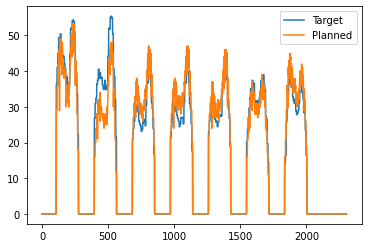

In [18]:
# and compare the planned staffing curve with the target

plt.plot(week2Planner.getTargetStaffing(), label="Target")
plt.plot(week2Planner.getPlannedStaffing(), label="Planned")
plt.legend()
plt.show()

In [19]:
# the optimization report 

print(week1Planner.getReport())


          turning length: 7
                 week n°: 0
             slot length: 5 minutes
               agents n°: 99
         target staffing: 3250.00 hrs
      simulated staffing: 3249.17 hrs

   comfort energy weight: 0.00000

         annealing steps: 127
       temperature range: 8.00000 -> 0.00001
    temperature schedule: 0.90
       optimization time: 3.0 minutes

         staffing energy: 22.16689 -> 9.25571
          comfort energy: 73707.42857 -> 107439.42857
            TOTAL ENERGY: 22.16689 -> 9.25571

     day by day staffing:
                 day   1: 550.50 hrs (target 589.81 hrs error 6.67%)
                 day   2: 456.83 hrs (target 518.17 hrs error 11.84%)
                 day   3: 424.33 hrs (target 442.87 hrs error 4.19%)
                 day   4: 460.67 hrs (target 438.53 hrs error -5.05%)
                 day   5: 474.00 hrs (target 408.06 hrs error -16.16%)
                 day   6: 382.17 hrs (target 425.94 hrs error 10.28%)
                 day   7: 500